In [1]:
import os
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display, Latex
from scipy import stats
from sklearn import metrics
from scipy.optimize import curve_fit

from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.layouts import row

import rp2.data
import rp2.environment
from rp2 import hagai_2018, create_gene_symbol_map
from rp2.environment import check_environment
from rp2.paths import get_output_path
from rp2.regression import power_function, calculate_curve_fit
from rp2 import paths, notebooks

from evolution import Load_data, Load_counts

check_environment()

nb = notebooks.initialise_environment("Burst_Parameters_In_Evolution",  dependencies=["Get_Responsive_Gene_Subset"])


### Settings controlling downstream analysis

In [2]:
analysis_species = ["mouse", "rat", "pig", "rabbit"]
analysis_counts = "median"
analysis_treatments_1 = ["unst", "lps", "pic"]
analysis_treatments_2 = ["unst", "lps"]
analysis_time_points = ["0", "2", "4", "6"]

default_huber_epsilon = 1.345
mv_rlm_factor = default_huber_epsilon
min_mv_r2 = 0.60
min_conditions = 10
min_conditions_2 = 6

bp_curve_loss = "huber"
bp_curve_f_scale = 1.00

condition_columns = ["replicate", "treatment", "time_point"]
index_columns = ["gene"] + condition_columns

In [3]:
for species in analysis_species:
    if species == "mouse":
        mouse_gene_symbol_map = create_gene_symbol_map(species)
    if species == "pig":
        pig_gene_symbol_map = create_gene_symbol_map(species)
    if species == "rat":
        rat_gene_symbol_map = create_gene_symbol_map(species)
    if species == "rabbit":
        rabbit_gene_symbol_map = create_gene_symbol_map(species)

### Determine which genes have a sufficient number of conditions with valid burst parameters

In [4]:
lps_responsive_mouse_genes = hagai_2018.load_lps_responsive_genes()
all_orthologues = rp2.load_mouse_orthologues()
analysis_orthologues = rp2.load_one_to_one_mouse_orthologues().loc[lps_responsive_mouse_genes].reset_index()
analysis_orthologues.columns = analysis_orthologues.columns.str.slice(0, -5)

responsive_genes = Load_data.load_responsive_analysis_genes()
responsive_orthologues = analysis_orthologues.loc[responsive_genes.loc[analysis_orthologues.mouse].responsive_in_all.to_numpy()]
print(f"  Using subset of {len(responsive_orthologues):,} genes that are responsive in all species.")

  Using subset of 218 genes that are responsive in all species.


In [5]:
print("In the mouse dataset:")
condition_info_df = rp2.data.load_and_recalculate_txburst_results("mouse", condition_columns, count_type=analysis_counts)
condition_info_df["k_burstiness"] = condition_info_df.k_off / condition_info_df.k_on
condition_info_df["log_burstiness"] = np.log(condition_info_df.k_burstiness)

condition_info_df = condition_info_df.loc[condition_info_df.treatment.isin(analysis_treatments_1)]
condition_info_df = condition_info_df.loc[condition_info_df.time_point.isin(analysis_time_points)]
print(f"{len(condition_info_df):,} conditions for {condition_info_df.gene.nunique():,} genes have been processed by txburst")

condition_info_df["valid_bp"] = condition_info_df.bs_point.notna() & condition_info_df.bf_point.notna()

print(f"{np.count_nonzero(condition_info_df.valid_bp):,} conditions have valid burst parameters")

valid_counts = condition_info_df.groupby("gene").valid_bp.agg(np.count_nonzero)
valid_gene_ids = valid_counts.index[valid_counts >= min_conditions]
print(f"{len(valid_gene_ids):,} genes have {min_conditions} or more conditions with valid burst parameters")

responsive_genes_array = responsive_orthologues.mouse.to_numpy()

condition_info_df = condition_info_df.loc[condition_info_df.gene.isin(valid_gene_ids)]
condition_info_df = condition_info_df.loc[condition_info_df.gene.isin(responsive_genes_array)]

condition_info_df

In the mouse dataset:
11,604 conditions for 2,303 genes have been processed by txburst
11,604 conditions have valid burst parameters
123 genes have 10 or more conditions with valid burst parameters


,gene,replicate,treatment,time_point,k_on,k_off,k_syn,bf_point,bs_point,k_burstiness,log_burstiness,valid_bp
609,ENSMUSG00000000982,1,unst,0,0.386638,683.273314,2287.934151,0.386420,3.348490,1767.215043,7.477160,True
610,ENSMUSG00000000982,1,lps,2,3.086254,227.241050,2568.117556,3.044900,11.301292,73.630064,4.299053,True
611,ENSMUSG00000000982,1,pic,2,0.571632,84.648308,686.407569,0.567797,8.108934,148.081896,4.997765,True
612,ENSMUSG00000000982,1,lps,4,4.704826,216.103397,3371.206017,4.604579,15.599968,45.932279,3.827168,True
613,ENSMUSG00000000982,1,pic,4,0.524835,136.405444,943.513874,0.522823,6.916981,259.901650,5.560303,True
...,...,...,...,...,...,...,...,...,...,...,...,...
48287,ENSMUSG00000074622,2,pic,2,0.611458,425.492453,775.112593,0.610580,1.821684,695.865934,6.545157,True
48289,ENSMUSG00000074622,2,pic,4,0.744034,139.690663,255.687165,0.740092,1.830381,187.747637,5.235099,True
48291,ENSMUSG00000074622,2,pic,6,0.966770,46.602129,53.699110,0.947122,1.152289,48.203955,3.875441,True
48295,ENSMUSG00000074622,3,pic,2,0.834287,864.223978,916.321487,0.833482,1.060282,1035.883173,6.943010,True


In [6]:
gene_list = []

for gene in condition_info_df.gene:
    if gene not in gene_list:
        gene_list.append(gene)
print("Number of responsive mouse genes in analysis:" , len(gene_list))

Number of responsive mouse genes in analysis: 34


In [7]:
print("In the rat dataset:")
rat_condition_info_df = rp2.data.load_and_recalculate_txburst_results("rat", condition_columns, count_type=analysis_counts)
rat_condition_info_df["k_burstiness"] = rat_condition_info_df.k_off / rat_condition_info_df.k_on
rat_condition_info_df["log_burstiness"] = np.log(rat_condition_info_df.k_burstiness)

rat_condition_info_df = rat_condition_info_df.loc[rat_condition_info_df.treatment.isin(analysis_treatments_1)]
rat_condition_info_df = rat_condition_info_df.loc[rat_condition_info_df.time_point.isin(analysis_time_points)]
print(f"{len(rat_condition_info_df):,} conditions for {rat_condition_info_df.gene.nunique():,} rat genes have been processed by txburst")

rat_condition_info_df["valid_bp"] = rat_condition_info_df.bs_point.notna() & rat_condition_info_df.bf_point.notna()

print(f"{np.count_nonzero(rat_condition_info_df.valid_bp):,} conditions have valid burst parameters")

rat_valid_counts = rat_condition_info_df.groupby("gene").valid_bp.agg(np.count_nonzero)
rat_valid_gene_ids = rat_valid_counts.index[rat_valid_counts >= min_conditions]
print(f"{len(rat_valid_gene_ids):,} rat genes have {min_conditions} or more conditions with valid burst parameters")


responsive_genes_rat_array = responsive_orthologues.rat.to_numpy()

rat_condition_info_df = rat_condition_info_df.loc[rat_condition_info_df.gene.isin(rat_valid_gene_ids)]
rat_condition_info_df = rat_condition_info_df.loc[rat_condition_info_df.gene.isin(responsive_genes_rat_array)]

rat_condition_info_df

In the rat dataset:
6,530 conditions for 1,678 rat genes have been processed by txburst
6,530 conditions have valid burst parameters
169 rat genes have 10 or more conditions with valid burst parameters


,gene,replicate,treatment,time_point,k_on,k_off,k_syn,bf_point,bs_point,k_burstiness,log_burstiness,valid_bp
588,ENSRNOG00000000394,1,unst,0,0.926111,157.352115,347.550543,0.920692,2.208744,169.906308,5.135247,True
589,ENSRNOG00000000394,1,lps,2,1.219659,133.539125,541.206742,1.208620,4.052795,109.488921,4.695823,True
590,ENSRNOG00000000394,1,pic,2,0.914172,287.319135,637.925332,0.911272,2.220267,314.294476,5.750330,True
591,ENSRNOG00000000394,1,lps,4,1.600618,259.749896,1333.341195,1.590815,5.133173,162.280981,5.089329,True
592,ENSRNOG00000000394,1,pic,4,0.981628,85.832448,293.650247,0.970528,3.421203,87.438916,4.470940,True
...,...,...,...,...,...,...,...,...,...,...,...,...
46886,ENSRNOG00000056219,3,unst,0,0.137439,93.643152,106.125617,0.137238,1.133298,681.341643,6.524064,True
46887,ENSRNOG00000056219,3,lps,2,1.769011,86.711404,231.265112,1.733643,2.667067,49.016884,3.892165,True
46889,ENSRNOG00000056219,3,lps,4,1.169433,122.689811,460.952827,1.158391,3.757059,104.913959,4.653141,True
46890,ENSRNOG00000056219,3,pic,4,0.166104,158.823303,378.911340,0.165930,2.385741,956.167941,6.862934,True


In [8]:
rat_gene_list = []

for gene in rat_condition_info_df.gene:
    if gene not in rat_gene_list:
        rat_gene_list.append(gene)
print("Number of responsive rat genes in analysis:" , len(rat_gene_list))

Number of responsive rat genes in analysis: 45


In [9]:
print("In the pig dataset:")

pig_condition_info_df = rp2.data.load_and_recalculate_txburst_results("pig", condition_columns, count_type=analysis_counts)
pig_condition_info_df["k_burstiness"] = pig_condition_info_df.k_off / pig_condition_info_df.k_on
pig_condition_info_df["log_burstiness"] = np.log(pig_condition_info_df.k_burstiness)

pig_condition_info_df = pig_condition_info_df.loc[pig_condition_info_df.treatment.isin(analysis_treatments_2)]
pig_condition_info_df = pig_condition_info_df.loc[pig_condition_info_df.time_point.isin(analysis_time_points)]
print(f"{len(pig_condition_info_df):,} conditions for {pig_condition_info_df.gene.nunique():,} pig genes have been processed by txburst")

pig_condition_info_df["valid_bp"] = pig_condition_info_df.bs_point.notna() & pig_condition_info_df.bf_point.notna()

print(f"{np.count_nonzero(pig_condition_info_df.valid_bp):,} conditions have valid burst parameters")

pig_valid_counts = pig_condition_info_df.groupby("gene").valid_bp.agg(np.count_nonzero)
pig_valid_gene_ids = pig_valid_counts.index[pig_valid_counts >= min_conditions_2]
print(f"{len(pig_valid_gene_ids):,} pig genes have {min_conditions_2} or more conditions with valid burst parameters")

responsive_genes_pig_array = responsive_orthologues.pig.to_numpy()

pig_condition_info_df = pig_condition_info_df.loc[pig_condition_info_df.gene.isin(pig_valid_gene_ids)]
pig_condition_info_df = pig_condition_info_df.loc[pig_condition_info_df.gene.isin(responsive_genes_pig_array)]

pig_condition_info_df

In the pig dataset:
2,117 conditions for 783 pig genes have been processed by txburst
2,117 conditions have valid burst parameters
90 pig genes have 6 or more conditions with valid burst parameters


,gene,replicate,treatment,time_point,k_on,k_off,k_syn,bf_point,bs_point,k_burstiness,log_burstiness,valid_bp
277,ENSSSCG00000000181,1,lps,2,0.106763,299.897288,463.199044,0.106725,1.544526,2809.012199,7.940588,True
281,ENSSSCG00000000181,2,lps,2,0.231379,49.159085,93.347795,0.230295,1.898892,212.461300,5.358760,True
282,ENSSSCG00000000181,2,lps,4,0.128013,38.445246,76.967089,0.127588,2.001992,300.323262,5.704859,True
285,ENSSSCG00000000181,3,lps,2,0.212483,31.872852,50.414275,0.211076,1.581731,150.002118,5.010649,True
286,ENSSSCG00000000181,3,lps,4,0.243104,328.064724,559.376372,0.242924,1.705079,1349.480290,7.207475,True
...,...,...,...,...,...,...,...,...,...,...,...,...
28027,ENSSSCG00000030898,2,lps,6,2.122136,120.094285,369.024084,2.085288,3.072786,56.591233,4.035854,True
28028,ENSSSCG00000030898,3,unst,0,2.934112,6.509876,39.056551,2.022525,5.999585,2.218687,0.796915,True
28029,ENSSSCG00000030898,3,lps,2,1.411344,188.552645,546.312689,1.400859,2.897401,133.597893,4.894834,True
28030,ENSSSCG00000030898,3,lps,4,1.432855,256.351434,751.791344,1.424891,2.932659,178.909508,5.186880,True


In [10]:
pig_gene_list = []

for gene in pig_condition_info_df.gene:
    if gene not in pig_gene_list:
        pig_gene_list.append(gene)
print("Number of responsive pig genes in analysis:" , len(pig_gene_list))

Number of responsive pig genes in analysis: 37


In [11]:
print("In the rabbit dataset:")

rabbit_condition_info_df = rp2.data.load_and_recalculate_txburst_results("rabbit", condition_columns, count_type=analysis_counts)
rabbit_condition_info_df["k_burstiness"] = rabbit_condition_info_df.k_off / rabbit_condition_info_df.k_on
rabbit_condition_info_df["log_burstiness"] = np.log(rabbit_condition_info_df.k_burstiness)

rabbit_condition_info_df = rabbit_condition_info_df.loc[rabbit_condition_info_df.treatment.isin(analysis_treatments_2)]
rabbit_condition_info_df = rabbit_condition_info_df.loc[rabbit_condition_info_df.time_point.isin(analysis_time_points)]
print(f"{len(rabbit_condition_info_df):,} conditions for {rabbit_condition_info_df.gene.nunique():,} rabbit genes have been processed by txburst")

rabbit_condition_info_df["valid_bp"] = rabbit_condition_info_df.bs_point.notna() & rabbit_condition_info_df.bf_point.notna()

print(f"{np.count_nonzero(rabbit_condition_info_df.valid_bp):,} conditions have valid burst parameters")

rabbit_valid_counts = rabbit_condition_info_df.groupby("gene").valid_bp.agg(np.count_nonzero)
rabbit_valid_gene_ids = rabbit_valid_counts.index[rabbit_valid_counts >= min_conditions_2]
print(f"{len(rabbit_valid_gene_ids):,} rabbit genes have {min_conditions_2} or more conditions with valid burst parameters")

responsive_genes_rabbit_array = responsive_orthologues.rabbit.to_numpy()

rabbit_condition_info_df = rabbit_condition_info_df.loc[rabbit_condition_info_df.gene.isin(rabbit_valid_gene_ids)]
rabbit_condition_info_df = rabbit_condition_info_df.loc[rabbit_condition_info_df.gene.isin(responsive_genes_rabbit_array)]

rabbit_condition_info_df

In the rabbit dataset:
1,322 conditions for 743 rabbit genes have been processed by txburst
1,322 conditions have valid burst parameters
46 rabbit genes have 6 or more conditions with valid burst parameters


,gene,replicate,treatment,time_point,k_on,k_off,k_syn,bf_point,bs_point,k_burstiness,log_burstiness,valid_bp
109,ENSOCUG00000000114,1,lps,2,0.786393,1.879833,20.436018,0.554449,10.871190,2.390450,0.871482,True
110,ENSOCUG00000000114,1,lps,4,0.393415,159.095855,407.235179,0.392445,2.559684,404.396559,6.002396,True
113,ENSOCUG00000000114,2,lps,2,0.590047,132.850704,506.237992,0.587438,3.810578,225.152809,5.416779,True
114,ENSOCUG00000000114,2,lps,4,0.241020,82.461117,145.690586,0.240318,1.766779,342.133384,5.835201,True
117,ENSOCUG00000000114,3,lps,2,0.660875,85.901416,242.155551,0.655829,2.818994,129.981403,4.867391,True
...,...,...,...,...,...,...,...,...,...,...,...,...
28014,ENSOCUG00000029644,2,lps,4,2.742322,553.009163,988.579781,2.728791,1.787637,201.657242,5.306569,True
28016,ENSOCUG00000029644,3,unst,0,0.002477,0.006357,1.623030,0.001783,255.299919,2.566131,0.942399,True
28017,ENSOCUG00000029644,3,lps,2,3.067456,125.793090,155.368216,2.994437,1.235109,41.008932,3.713790,True
28018,ENSOCUG00000029644,3,lps,4,2.213031,354.501712,574.934249,2.199301,1.621810,160.188342,5.076350,True


In [12]:
rabbit_gene_list = []

for gene in rabbit_condition_info_df.gene:
    if gene not in rabbit_gene_list:
        rabbit_gene_list.append(gene)
print("Number of responsive rabbit genes in analysis:" , len(rabbit_gene_list))

Number of responsive rabbit genes in analysis: 22


### Calculate statistics of RNA counts

In [13]:
def calculate_count_stats(condition_subset):
    counts_adata = hagai_2018.load_counts("mouse", scaling=analysis_counts)
    print(f"Counts available for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    counts_adata = counts_adata[:, counts_adata.var_names.isin(condition_subset.gene)]
    for column in condition_columns:
        counts_adata = counts_adata[counts_adata.obs[column].isin(condition_subset[column])]

    counts_adata = counts_adata.copy()
    print(f"Calculating count statistics for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    stats_df = hagai_2018.calculate_counts_condition_stats(counts_adata, group_columns=condition_columns)

    return stats_df

print("Analysis of mouse genes:")
condition_info_df = condition_info_df.set_index(index_columns).join(
    calculate_count_stats(condition_info_df).set_index(index_columns),
    how="left",
).reset_index()

condition_info_df

Analysis of mouse genes:
Counts available for 55,898 cells and 16,798 genes
Calculating count statistics for 53,086 cells and 34 genes


,gene,replicate,treatment,time_point,k_on,k_off,k_syn,bf_point,bs_point,k_burstiness,log_burstiness,valid_bp,n_barcodes,min,max,mean,variance,std_dev,skew
0,ENSMUSG00000000982,1,unst,0,0.386638,683.273314,2287.934151,0.386420,3.348490,1767.215043,7.477160,True,2126,0.000000,25.744102,1.293213,5.697190,2.386879,3.758048
1,ENSMUSG00000000982,1,lps,2,3.086254,227.241050,2568.117556,3.044900,11.301292,73.630064,4.299053,True,2537,0.000000,317.090515,34.495232,519.064697,22.782991,2.490452
2,ENSMUSG00000000982,1,pic,2,0.571632,84.648308,686.407569,0.567797,8.108934,148.081896,4.997765,True,3025,0.000000,114.417152,4.617060,47.470352,6.889873,4.035792
3,ENSMUSG00000000982,1,lps,4,4.704826,216.103397,3371.206017,4.604579,15.599968,45.932279,3.827168,True,2366,5.562234,383.941772,71.836594,1246.800781,35.310066,1.553738
4,ENSMUSG00000000982,1,pic,4,0.524835,136.405444,943.513874,0.522823,6.916981,259.901650,5.560303,True,2394,0.000000,164.152100,3.728203,51.826103,7.199035,10.232024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,ENSMUSG00000074622,2,pic,2,0.611458,425.492453,775.112593,0.610580,1.821684,695.865934,6.545157,True,3322,0.000000,36.093246,1.233325,4.254582,2.062664,3.626854
463,ENSMUSG00000074622,2,pic,4,0.744034,139.690663,255.687165,0.740092,1.830381,187.747637,5.235099,True,2718,0.000000,26.654060,1.333257,3.837730,1.959012,2.813694
464,ENSMUSG00000074622,2,pic,6,0.966770,46.602129,53.699110,0.947122,1.152289,48.203955,3.875441,True,2775,0.000000,12.583791,1.077631,2.259318,1.503103,2.093196
465,ENSMUSG00000074622,3,pic,2,0.834287,864.223978,916.321487,0.833482,1.060282,1035.883173,6.943010,True,2760,0.000000,13.243224,0.858468,1.990251,1.410762,2.722089


In [14]:
def calculate_count_stats_rat(condition_subset):
    counts_adata = Load_counts.load_counts("rat", scaling=analysis_counts)
    print(f"Counts available for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    counts_adata = counts_adata[:, counts_adata.var_names.isin(condition_subset.gene)]
    for column in condition_columns:
        counts_adata = counts_adata[counts_adata.obs[column].isin(condition_subset[column])]

    counts_adata = counts_adata.copy()
    print(f"Calculating count statistics for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    stats_df = hagai_2018.calculate_counts_condition_stats(counts_adata, group_columns=condition_columns)

    return stats_df

print("Analysis of rat genes: ")
rat_condition_info_df = rat_condition_info_df.set_index(index_columns).join(
    calculate_count_stats_rat(rat_condition_info_df).set_index(index_columns),
    how="left",
).reset_index()

Analysis of rat genes: 
Counts available for 50,185 cells and 16,780 genes
Calculating count statistics for 50,185 cells and 45 genes


In [16]:
def calculate_count_stats_pig(condition_subset):
    counts_adata = Load_counts.load_counts("pig", scaling=analysis_counts)
    print(f"Counts available for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    counts_adata = counts_adata[:, counts_adata.var_names.isin(condition_subset.gene)]
    for column in condition_columns:
        counts_adata = counts_adata[counts_adata.obs[column].isin(condition_subset[column])]

    counts_adata = counts_adata.copy()
    print(f"Calculating count statistics for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    stats_df = hagai_2018.calculate_counts_condition_stats(counts_adata, group_columns=condition_columns)

    return stats_df

print("Analysis of pig genes: ")
pig_condition_info_df = pig_condition_info_df.set_index(index_columns).join(
    calculate_count_stats_pig(pig_condition_info_df).set_index(index_columns),
    how="left",
).reset_index()

Analysis of pig genes: 
Counts available for 23,469 cells and 15,602 genes
Calculating count statistics for 23,469 cells and 37 genes


In [17]:
def calculate_count_stats_rabbit(condition_subset):
    counts_adata = Load_counts.load_counts("rabbit", scaling=analysis_counts)
    print(f"Counts available for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    counts_adata = counts_adata[:, counts_adata.var_names.isin(condition_subset.gene)]
    for column in condition_columns:
        counts_adata = counts_adata[counts_adata.obs[column].isin(condition_subset[column])]

    counts_adata = counts_adata.copy()
    print(f"Calculating count statistics for {counts_adata.n_obs:,} cells and {counts_adata.n_vars:,} genes")

    stats_df = hagai_2018.calculate_counts_condition_stats(counts_adata, group_columns=condition_columns)

    return stats_df

print("Analysis of rabbit genes: ")
rabbit_condition_info_df = rabbit_condition_info_df.set_index(index_columns).join(
    calculate_count_stats_rabbit(rabbit_condition_info_df).set_index(index_columns),
    how="left",
).reset_index()

Analysis of rabbit genes: 
Counts available for 34,528 cells and 14,480 genes
Calculating count statistics for 34,528 cells and 22 genes


### Display an interactive mean-variance plot for genes with sufficient conditions with valid burst parameters

Although the list of genes is restricted to those with a minimum number of conditions with valid burst parameters, all conditions are plotted and used to fit the regression line.

Plotted points are scaled according to the weight they are assigned by the robust linear model. The sensitivity of the model to outliers can be adjusted rlm_factor slider. Changes to this value are for illustration only and will not change downstream analysis (for this, change the value of mv_rlm_factor above and re-run all cells).

In [18]:
def apply_huber_regressor(df, x_var, y_var, epsilon, include_weights=False):
    x, y = df.loc[:, [x_var, y_var]].to_numpy().T
    x = sm.add_constant(x)

    lm_res = sm.RLM(y, x, sm.robust.norms.HuberT(t=epsilon)).fit()

    results = {
        "slope": lm_res.params[1],
        "intercept": lm_res.params[0],
    }

    r2_unweighted = metrics.r2_score(y, lm_res.predict(x))
    if include_weights:
        results["r2_unweighted"] = r2_unweighted
        results["r2_weighted"] = metrics.r2_score(y, lm_res.predict(x), sample_weight=lm_res.weights)
        results["weights"] = lm_res.weights
    else:
        results["r2"] = r2_unweighted

    return results


def apply_mv_regressor(df, x_var, y_var, epsilon=mv_rlm_factor):
    return apply_huber_regressor(df, x_var, y_var, epsilon, include_weights=True)


def apply_standard_regressor(df, x_var, y_var):
    return apply_huber_regressor(df, x_var, y_var, epsilon=default_huber_epsilon)


def make_mouse_gene_selector(gene_ids):
    gene_symbols = mouse_gene_symbol_map.lookup(gene_ids).sort_values()
    return widgets.Select(
        options=list(zip(gene_symbols.values, gene_symbols.index)),
        rows=3,
    )

def make_rat_gene_selector(gene_ids):
    gene_symbols = rat_gene_symbol_map.lookup(gene_ids).sort_values()
    return widgets.Select(
        options=list(zip(gene_symbols.values, gene_symbols.index)),
        rows=3,
    )

def make_pig_gene_selector(gene_ids):
    gene_symbols = pig_gene_symbol_map.lookup(gene_ids).sort_values()
    return widgets.Select(
        options=list(zip(gene_symbols.values, gene_symbols.index)),
        rows=3,
    )

def make_rabbit_gene_selector(gene_ids):
    gene_symbols = rabbit_gene_symbol_map.lookup(gene_ids).sort_values()
    return widgets.Select(
        options=list(zip(gene_symbols.values, gene_symbols.index)),
        rows=3,
    )


def format_plus_c(c):
    return f"+{c:.2f}" if c > 0 else f"-{abs(c):.2f}"

In [19]:
def plot_mean_var_mouse(gene_id, scale, plot_treatment_lines, rlm_factor):
    treatment_colour_map = {"unst": "black", "lps": "red", "pic": "green"}

    condition_info_subset = condition_info_df.loc[condition_info_df.gene == gene_id]

    lr_results = apply_mv_regressor(condition_info_subset, "mean", "variance", rlm_factor)
    lr_weights = lr_results["weights"]

    treatment_lr_results_map = {treatment: apply_mv_regressor(condition_info_subset.loc[condition_info_subset.treatment.isin(["unst", treatment])], "mean", "variance")
                                for treatment in filter(lambda t: t != "unst", analysis_treatments_1)}

    plot_output = widgets.Output()
    info_output = widgets.Output()

    with plot_output:
        colours = condition_info_subset.treatment.map(treatment_colour_map)
        legend_handles = []
        for treatment_name, colour in treatment_colour_map.items():
            legend_handles.append(matplotlib.lines.Line2D([], [], marker="o", color=colour, label=treatment_name, linestyle="None", markersize=8))

        is_log = scale == "log"
        log_shift = 1 if is_log else 0
        space_function = np.geomspace if is_log else np.linspace

        x, y = condition_info_subset.loc[:, ["mean", "variance"]].to_numpy().T
        s = np.interp(lr_weights, (0, 1), (10, 50))
        plt.scatter(x + log_shift, y + log_shift, c=colours, s=s)

        lr_x = space_function(log_shift, x.max() + log_shift)
        lr_y = ((lr_x - log_shift) * lr_results["slope"]) + lr_results["intercept"]
        plt.plot(lr_x, lr_y + log_shift, "-")

        if plot_treatment_lines:
            for treatment, lr_res in treatment_lr_results_map.items():
                lr_y2 = ((lr_x - log_shift) * lr_res["slope"]) + lr_res["intercept"]
                plt.plot(lr_x, lr_y2 + log_shift, ":", c=treatment_colour_map[treatment])

        plt.xscale(scale)
        plt.xlim(left=log_shift)
        plt.xlabel("Mean count ($\mu$)")
        plt.yscale(scale)
        plt.ylim(bottom=log_shift)
        plt.ylabel("Variance ($\sigma^2$)")
        plt.legend(
            handles=legend_handles,
            loc="upper left",
            bbox_to_anchor=(1, 1)
        )
        plt.show()

    with info_output:
        print(f"No. of conditions with burst parameters: {np.count_nonzero(condition_info_subset.valid_bp)} / {len(condition_info_subset)}")
        print(f"No. of weights < 1: {np.count_nonzero(lr_weights < 1)}")
        for treatment in analysis_treatments_1:
            print(f"  {np.count_nonzero((lr_weights < 1) & (condition_info_subset.treatment == treatment))} {treatment}")
        display(Latex(f"$\sigma^2={lr_results['slope']:.2f}\mu{format_plus_c(lr_results['intercept'])}$"))
        display(Latex(f"Weighted $R^2$: {lr_results['r2_weighted']:.3f}"))
        display(Latex(f"Unweighted $R^2$: {lr_results['r2_unweighted']:.3f}"))

        for name, treatment_lr_results in treatment_lr_results_map.items():
            display(Latex(f"Unweighted $R_{{{name}}}^2$: {treatment_lr_results['r2_unweighted']:.3f}"))


    display(widgets.HBox((plot_output, info_output)))


widgets.interactive(
    plot_mean_var_mouse,
    gene_id=make_mouse_gene_selector(gene_list),
    scale=widgets.RadioButtons(options=[["Linear", "linear"], ["Log-log (+1)", "log"]]),
    plot_treatment_lines=False,
    rlm_factor=widgets.FloatSlider(mv_rlm_factor, min=1.001, max=5, step=0.001, readout_format=".3f"),
)

interactive(children=(Select(description='gene_id', options=(('Acsl1', 'ENSMUSG00000018796'), ('Ccl2', 'ENSMUS…

In [20]:
def plot_mean_var_rat(gene_id, scale, plot_treatment_lines, rlm_factor):
    treatment_colour_map = {"unst": "black", "lps": "red", "pic": "green"}

    rat_condition_info_subset = rat_condition_info_df.loc[rat_condition_info_df.gene == gene_id]

    lr_results = apply_mv_regressor(rat_condition_info_subset, "mean", "variance", rlm_factor)
    lr_weights = lr_results["weights"]

    treatment_lr_results_map = {treatment: apply_mv_regressor(rat_condition_info_subset.loc[rat_condition_info_subset.treatment.isin(["unst", treatment])], "mean", "variance")
                                for treatment in filter(lambda t: t != "unst", analysis_treatments_1)}

    plot_output = widgets.Output()
    info_output = widgets.Output()

    with plot_output:
        colours = rat_condition_info_subset.treatment.map(treatment_colour_map)
        legend_handles = []
        for treatment_name, colour in treatment_colour_map.items():
            legend_handles.append(matplotlib.lines.Line2D([], [], marker="o", color=colour, label=treatment_name, linestyle="None", markersize=8))

        is_log = scale == "log"
        log_shift = 1 if is_log else 0
        space_function = np.geomspace if is_log else np.linspace

        x, y = rat_condition_info_subset.loc[:, ["mean", "variance"]].to_numpy().T
        s = np.interp(lr_weights, (0, 1), (10, 50))
        plt.scatter(x + log_shift, y + log_shift, c=colours, s=s)

        lr_x = space_function(log_shift, x.max() + log_shift)
        lr_y = ((lr_x - log_shift) * lr_results["slope"]) + lr_results["intercept"]
        plt.plot(lr_x, lr_y + log_shift, "-")

        if plot_treatment_lines:
            for treatment, lr_res in treatment_lr_results_map.items():
                lr_y2 = ((lr_x - log_shift) * lr_res["slope"]) + lr_res["intercept"]
                plt.plot(lr_x, lr_y2 + log_shift, ":", c=treatment_colour_map[treatment])

        plt.xscale(scale)
        plt.xlim(left=log_shift)
        plt.xlabel("Mean count ($\mu$)")
        plt.yscale(scale)
        plt.ylim(bottom=log_shift)
        plt.ylabel("Variance ($\sigma^2$)")
        plt.legend(
            handles=legend_handles,
            loc="upper left",
            bbox_to_anchor=(1, 1)
        )
        plt.show()

    with info_output:
        print(f"No. of conditions with burst parameters: {np.count_nonzero(rat_condition_info_subset.valid_bp)} / {len(rat_condition_info_subset)}")
        print(f"No. of weights < 1: {np.count_nonzero(lr_weights < 1)}")
        for treatment in analysis_treatments_1:
            print(f"  {np.count_nonzero((lr_weights < 1) & (rat_condition_info_subset.treatment == treatment))} {treatment}")
        display(Latex(f"$\sigma^2={lr_results['slope']:.2f}\mu{format_plus_c(lr_results['intercept'])}$"))
        display(Latex(f"Weighted $R^2$: {lr_results['r2_weighted']:.3f}"))
        display(Latex(f"Unweighted $R^2$: {lr_results['r2_unweighted']:.3f}"))

        for name, treatment_lr_results in treatment_lr_results_map.items():
            display(Latex(f"Unweighted $R_{{{name}}}^2$: {treatment_lr_results['r2_unweighted']:.3f}"))


    display(widgets.HBox((plot_output, info_output)))


widgets.interactive(
    plot_mean_var_rat,
    gene_id=make_rat_gene_selector(rat_gene_list),
    scale=widgets.RadioButtons(options=[["Linear", "linear"], ["Log-log (+1)", "log"]]),
    plot_treatment_lines=False,
    rlm_factor=widgets.FloatSlider(mv_rlm_factor, min=1.001, max=5, step=0.001, readout_format=".3f"),
)

interactive(children=(Select(description='gene_id', options=(('Ccdc34', 'ENSRNOG00000005902'), ('Ccl2', 'ENSRN…

In [21]:
def plot_mean_var_pig(gene_id, scale, plot_treatment_lines, rlm_factor):
    treatment_colour_map = {"unst": "black", "lps": "red", "pic": "green"}

    pig_condition_info_subset = pig_condition_info_df.loc[pig_condition_info_df.gene == gene_id]

    lr_results = apply_mv_regressor(pig_condition_info_subset, "mean", "variance", rlm_factor)
    lr_weights = lr_results["weights"]

    treatment_lr_results_map = {treatment: apply_mv_regressor(pig_condition_info_subset.loc[pig_condition_info_subset.treatment.isin(["unst", treatment])], "mean", "variance")
                                for treatment in filter(lambda t: t != "unst", analysis_treatments_2)}

    plot_output = widgets.Output()
    info_output = widgets.Output()

    with plot_output:
        colours = pig_condition_info_subset.treatment.map(treatment_colour_map)
        legend_handles = []
        for treatment_name, colour in treatment_colour_map.items():
            legend_handles.append(matplotlib.lines.Line2D([], [], marker="o", color=colour, label=treatment_name, linestyle="None", markersize=8))

        is_log = scale == "log"
        log_shift = 1 if is_log else 0
        space_function = np.geomspace if is_log else np.linspace

        x, y = pig_condition_info_subset.loc[:, ["mean", "variance"]].to_numpy().T
        s = np.interp(lr_weights, (0, 1), (10, 50))
        plt.scatter(x + log_shift, y + log_shift, c=colours, s=s)

        lr_x = space_function(log_shift, x.max() + log_shift)
        lr_y = ((lr_x - log_shift) * lr_results["slope"]) + lr_results["intercept"]
        plt.plot(lr_x, lr_y + log_shift, "-")

        if plot_treatment_lines:
            for treatment, lr_res in treatment_lr_results_map.items():
                lr_y2 = ((lr_x - log_shift) * lr_res["slope"]) + lr_res["intercept"]
                plt.plot(lr_x, lr_y2 + log_shift, ":", c=treatment_colour_map[treatment])

        plt.xscale(scale)
        plt.xlim(left=log_shift)
        plt.xlabel("Mean count ($\mu$)")
        plt.yscale(scale)
        plt.ylim(bottom=log_shift)
        plt.ylabel("Variance ($\sigma^2$)")
        plt.legend(
            handles=legend_handles,
            loc="upper left",
            bbox_to_anchor=(1, 1)
        )
        plt.show()

    with info_output:
        print(f"No. of conditions with burst parameters: {np.count_nonzero(pig_condition_info_subset.valid_bp)} / {len(pig_condition_info_subset)}")
        print(f"No. of weights < 1: {np.count_nonzero(lr_weights < 1)}")
        for treatment in analysis_treatments_2:
            print(f"  {np.count_nonzero((lr_weights < 1) & (pig_condition_info_subset.treatment == treatment))} {treatment}")
        display(Latex(f"$\sigma^2={lr_results['slope']:.2f}\mu{format_plus_c(lr_results['intercept'])}$"))
        display(Latex(f"Weighted $R^2$: {lr_results['r2_weighted']:.3f}"))
        display(Latex(f"Unweighted $R^2$: {lr_results['r2_unweighted']:.3f}"))

        for name, treatment_lr_results in treatment_lr_results_map.items():
            display(Latex(f"Unweighted $R_{{{name}}}^2$: {treatment_lr_results['r2_unweighted']:.3f}"))


    display(widgets.HBox((plot_output, info_output)))


widgets.interactive(
    plot_mean_var_pig,
    gene_id=make_pig_gene_selector(pig_gene_list),
    scale=widgets.RadioButtons(options=[["Linear", "linear"], ["Log-log (+1)", "log"]]),
    plot_treatment_lines=False,
    rlm_factor=widgets.FloatSlider(mv_rlm_factor, min=1.001, max=5, step=0.001, readout_format=".3f"),
)

interactive(children=(Select(description='gene_id', options=(('CCL2', 'ENSSSCG00000017723'), ('CCL20', 'ENSSSC…

In [22]:
def plot_mean_var_rabbit(gene_id, scale, plot_treatment_lines, rlm_factor):
    treatment_colour_map = {"unst": "black", "lps": "red", "pic": "green"}

    rabbit_condition_info_subset = rabbit_condition_info_df.loc[rabbit_condition_info_df.gene == gene_id]

    lr_results = apply_mv_regressor(rabbit_condition_info_subset, "mean", "variance", rlm_factor)
    lr_weights = lr_results["weights"]

    treatment_lr_results_map = {treatment: apply_mv_regressor(rabbit_condition_info_subset.loc[rabbit_condition_info_subset.treatment.isin(["unst", treatment])], "mean", "variance")
                                for treatment in filter(lambda t: t != "unst", analysis_treatments_2)}

    plot_output = widgets.Output()
    info_output = widgets.Output()

    with plot_output:
        colours = rabbit_condition_info_subset.treatment.map(treatment_colour_map)
        legend_handles = []
        for treatment_name, colour in treatment_colour_map.items():
            legend_handles.append(matplotlib.lines.Line2D([], [], marker="o", color=colour, label=treatment_name, linestyle="None", markersize=8))

        is_log = scale == "log"
        log_shift = 1 if is_log else 0
        space_function = np.geomspace if is_log else np.linspace

        x, y = rabbit_condition_info_subset.loc[:, ["mean", "variance"]].to_numpy().T
        s = np.interp(lr_weights, (0, 1), (10, 50))
        plt.scatter(x + log_shift, y + log_shift, c=colours, s=s)

        lr_x = space_function(log_shift, x.max() + log_shift)
        lr_y = ((lr_x - log_shift) * lr_results["slope"]) + lr_results["intercept"]
        plt.plot(lr_x, lr_y + log_shift, "-")

        if plot_treatment_lines:
            for treatment, lr_res in treatment_lr_results_map.items():
                lr_y2 = ((lr_x - log_shift) * lr_res["slope"]) + lr_res["intercept"]
                plt.plot(lr_x, lr_y2 + log_shift, ":", c=treatment_colour_map[treatment])

        plt.xscale(scale)
        plt.xlim(left=log_shift)
        plt.xlabel("Mean count ($\mu$)")
        plt.yscale(scale)
        plt.ylim(bottom=log_shift)
        plt.ylabel("Variance ($\sigma^2$)")
        plt.legend(
            handles=legend_handles,
            loc="upper left",
            bbox_to_anchor=(1, 1)
        )
        plt.show()

    with info_output:
        print(f"No. of conditions with burst parameters: {np.count_nonzero(rabbit_condition_info_subset.valid_bp)} / {len(rabbit_condition_info_subset)}")
        print(f"No. of weights < 1: {np.count_nonzero(lr_weights < 1)}")
        for treatment in analysis_treatments_2:
            print(f"  {np.count_nonzero((lr_weights < 1) & (rabbit_condition_info_subset.treatment == treatment))} {treatment}")
        display(Latex(f"$\sigma^2={lr_results['slope']:.2f}\mu{format_plus_c(lr_results['intercept'])}$"))
        display(Latex(f"Weighted $R^2$: {lr_results['r2_weighted']:.3f}"))
        display(Latex(f"Unweighted $R^2$: {lr_results['r2_unweighted']:.3f}"))

        for name, treatment_lr_results in treatment_lr_results_map.items():
            display(Latex(f"Unweighted $R_{{{name}}}^2$: {treatment_lr_results['r2_unweighted']:.3f}"))


    display(widgets.HBox((plot_output, info_output)))


widgets.interactive(
    plot_mean_var_rabbit,
    gene_id=make_rabbit_gene_selector(rabbit_gene_list),
    scale=widgets.RadioButtons(options=[["Linear", "linear"], ["Log-log (+1)", "log"]]),
    plot_treatment_lines=False,
    rlm_factor=widgets.FloatSlider(mv_rlm_factor, min=1.001, max=5, step=0.001, readout_format=".3f"),
)

interactive(children=(Select(description='gene_id', options=(('CA4', 'ENSOCUG00000009399'), ('CCL2', 'ENSOCUG0…

### Fit trends to mean-variance relationships

A linear mean-variance trend is fitted and genes are further filtered by the $R^2$ score.

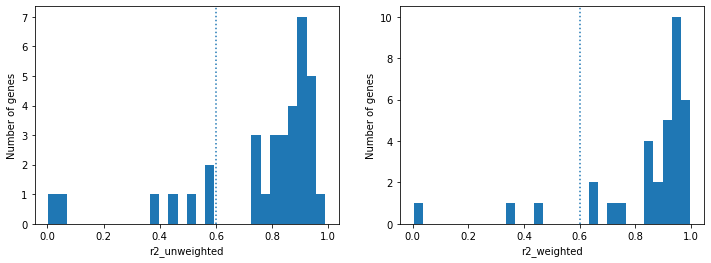

Of 34 genes:
  27 have (unweighted) R2 >= 0.6
  27 will be kept
The following genes will be filtered out:


,gene_symbol,slope,intercept,r2,n_valid_bp
gene,,,,,
ENSMUSG00000032330,Cox7a2,-0.234440,10.831475,0.003493,13
ENSMUSG00000027613,Eif6,0.781822,1.047935,0.591154,12
ENSMUSG00000026864,Hspa5,2.949814,0.657778,0.061256,15
ENSMUSG00000003541,Ier3,2.502134,1.653507,0.505960,11
ENSMUSG00000021701,Plk2,2.391611,0.206866,0.459024,14
ENSMUSG00000060073,Psma3,0.659715,1.137568,0.369874,14
ENSMUSG00000017009,Sdc4,12.487305,-6.550120,0.588629,18


In [23]:
condition_info_df["mv_weight"] = False
mv_gene_info_df = pd.DataFrame()

for gene_id, gene_df in condition_info_df.groupby("gene"):
    results = apply_mv_regressor(gene_df, "mean", "variance", mv_rlm_factor)
    weights = results.pop("weights")
    
    results["n_valid_bp"] = np.count_nonzero(gene_df.valid_bp)

    mv_gene_info_df = mv_gene_info_df.append(pd.DataFrame(index=[gene_id], data=results))
    condition_info_df.loc[gene_df.index, "mv_weight"] = weights

mv_gene_info_df.index.name = "gene"

_, axes = plt.subplots(ncols=2, figsize=(12, 4))
for r2_name, ax in zip(["r2_unweighted", "r2_weighted"], axes.flat):
    mv_gene_info_df[r2_name].plot.hist(bins=30, ax=ax)
    ax.axvline(x=min_mv_r2, ls=":", label="cutoff")
    ax.set_xlabel(r2_name)
    ax.set_ylabel("Number of genes")
plt.show()

mv_gene_info_df.drop(columns="r2_weighted", inplace=True)
mv_gene_info_df.rename(columns={"r2_unweighted": "r2"}, inplace=True)

print(f"Of {len(mv_gene_info_df):,} genes:")

subset_with_good_r2 = mv_gene_info_df.loc[mv_gene_info_df.r2 >= min_mv_r2]
print(f"  {len(subset_with_good_r2):,} have (unweighted) R2 >= {min_mv_r2}")
filtered_gene_ids = subset_with_good_r2.index

print(f"  {len(filtered_gene_ids):,} will be kept")
print("The following genes will be filtered out:")

mouse_gene_symbol_map.lookup(filtered_gene_ids).to_frame().sort_values(by="symbol").to_csv(get_output_path("burst_trends_gene_list.csv"), index_label="id")

display(mouse_gene_symbol_map.added_to(mv_gene_info_df.loc[~mv_gene_info_df.index.isin(filtered_gene_ids)]).sort_values(by="gene_symbol"))

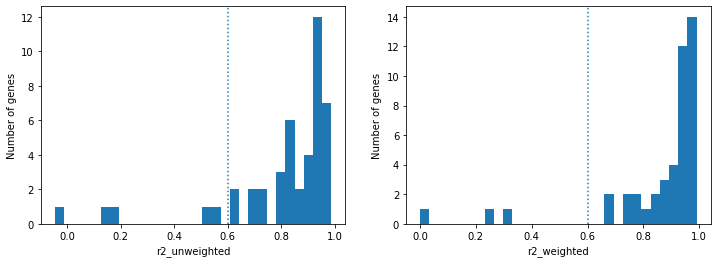

Of 45 genes:
  40 have (unweighted) R2 >= 0.6
  40 will be kept
The following genes will be filtered out:


,gene_symbol,slope,intercept,r2,n_valid_bp
gene,,,,,
ENSRNOG00000018294,Hspa5,17.529454,-83.952972,0.568050,20
ENSRNOG00000007851,Psma3,1.122108,4.327785,0.127523,12
ENSRNOG00000007114,Psma6,1.645748,1.668977,0.173881,15
ENSRNOG00000011732,Psmb7,-0.039911,10.214463,-0.046498,16
ENSRNOG00000055579,Tmbim6,2.246775,-0.520721,0.529231,16


In [24]:
rat_condition_info_df["mv_weight"] = False
mv_rat_gene_info_df = pd.DataFrame()

for gene_id, gene_df in rat_condition_info_df.groupby("gene"):
    results = apply_mv_regressor(gene_df, "mean", "variance", mv_rlm_factor)
    weights = results.pop("weights")
    
    results["n_valid_bp"] = np.count_nonzero(gene_df.valid_bp)

    mv_rat_gene_info_df = mv_rat_gene_info_df.append(pd.DataFrame(index=[gene_id], data=results))
    rat_condition_info_df.loc[gene_df.index, "mv_weight"] = weights

mv_rat_gene_info_df.index.name = "gene"

_, axes = plt.subplots(ncols=2, figsize=(12, 4))
for r2_name, ax in zip(["r2_unweighted", "r2_weighted"], axes.flat):
    mv_rat_gene_info_df[r2_name].plot.hist(bins=30, ax=ax)
    ax.axvline(x=min_mv_r2, ls=":", label="cutoff")
    ax.set_xlabel(r2_name)
    ax.set_ylabel("Number of genes")
plt.show()

mv_rat_gene_info_df.drop(columns="r2_weighted", inplace=True)
mv_rat_gene_info_df.rename(columns={"r2_unweighted": "r2"}, inplace=True)

print(f"Of {len(mv_rat_gene_info_df):,} genes:")

rat_subset_with_good_r2 = mv_rat_gene_info_df.loc[mv_rat_gene_info_df.r2 >= min_mv_r2]
print(f"  {len(rat_subset_with_good_r2):,} have (unweighted) R2 >= {min_mv_r2}")
filtered_rat_gene_ids = rat_subset_with_good_r2.index

print(f"  {len(filtered_rat_gene_ids):,} will be kept")
print("The following genes will be filtered out:")

rat_gene_symbol_map.lookup(filtered_rat_gene_ids).to_frame().sort_values(by="symbol").to_csv(get_output_path("burst_trends_rat_gene_list.csv"), index_label="id")

display(rat_gene_symbol_map.added_to(mv_rat_gene_info_df.loc[~mv_rat_gene_info_df.index.isin(filtered_rat_gene_ids)]).sort_values(by="gene_symbol"))

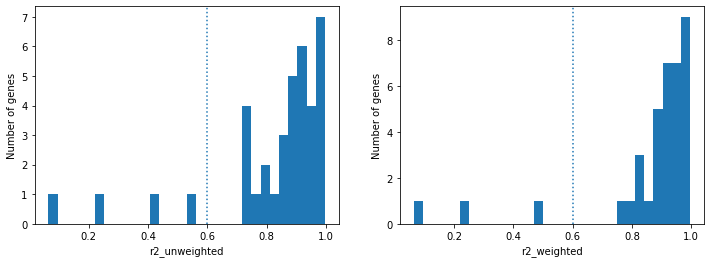

Of 37 genes:
  33 have (unweighted) R2 >= 0.6
  33 will be kept
The following genes will be filtered out:


,gene_symbol,slope,intercept,r2,n_valid_bp
gene,,,,,
ENSSSCG00000004480,COX7A2,1.186869,2.534519,0.432878,7
ENSSSCG00000015652,IL10,4.802756,2.064102,0.064112,7
ENSSSCG00000005385,NR4A3,3.014418,0.051168,0.535366,11
ENSSSCG00000006378,SLAMF7,2.185958,20.066706,0.241654,9


In [25]:
pig_condition_info_df["mv_weight"] = False
mv_pig_gene_info_df = pd.DataFrame()

for gene_id, gene_df in pig_condition_info_df.groupby("gene"):
    results = apply_mv_regressor(gene_df, "mean", "variance", mv_rlm_factor)
    weights = results.pop("weights")
    
    results["n_valid_bp"] = np.count_nonzero(gene_df.valid_bp)

    mv_pig_gene_info_df = mv_pig_gene_info_df.append(pd.DataFrame(index=[gene_id], data=results))
    pig_condition_info_df.loc[gene_df.index, "mv_weight"] = weights

mv_pig_gene_info_df.index.name = "gene"

_, axes = plt.subplots(ncols=2, figsize=(12, 4))
for r2_name, ax in zip(["r2_unweighted", "r2_weighted"], axes.flat):
    mv_pig_gene_info_df[r2_name].plot.hist(bins=30, ax=ax)
    ax.axvline(x=min_mv_r2, ls=":", label="cutoff")
    ax.set_xlabel(r2_name)
    ax.set_ylabel("Number of genes")
plt.show()

mv_pig_gene_info_df.drop(columns="r2_weighted", inplace=True)
mv_pig_gene_info_df.rename(columns={"r2_unweighted": "r2"}, inplace=True)

print(f"Of {len(mv_pig_gene_info_df):,} genes:")

pig_subset_with_good_r2 = mv_pig_gene_info_df.loc[mv_pig_gene_info_df.r2 >= min_mv_r2]
print(f"  {len(pig_subset_with_good_r2):,} have (unweighted) R2 >= {min_mv_r2}")
filtered_pig_gene_ids = pig_subset_with_good_r2.index

print(f"  {len(filtered_pig_gene_ids):,} will be kept")
print("The following genes will be filtered out:")

pig_gene_symbol_map.lookup(filtered_pig_gene_ids).to_frame().sort_values(by="symbol").to_csv(get_output_path("burst_trends_pig_gene_list.csv"), index_label="id")

display(pig_gene_symbol_map.added_to(mv_pig_gene_info_df.loc[~mv_pig_gene_info_df.index.isin(filtered_pig_gene_ids)]).sort_values(by="gene_symbol"))

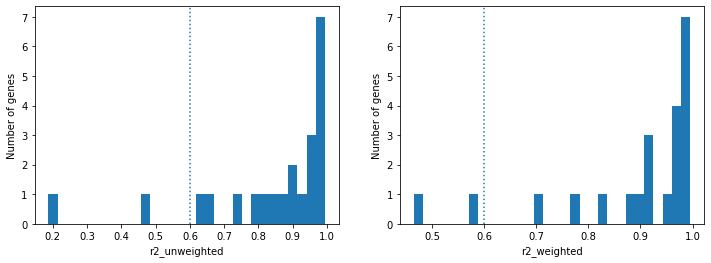

Of 22 genes:
  20 have (unweighted) R2 >= 0.6
  20 will be kept
The following genes will be filtered out:


,gene_symbol,slope,intercept,r2,n_valid_bp
gene,,,,,
ENSOCUG00000010316,PSMA3,1.111863,0.195923,0.187031,7
ENSOCUG00000001847,TMBIM6,2.079713,1.360623,0.464926,7


In [26]:
rabbit_condition_info_df["mv_weight"] = False
mv_rabbit_gene_info_df = pd.DataFrame()

for gene_id, gene_df in rabbit_condition_info_df.groupby("gene"):
    results = apply_mv_regressor(gene_df, "mean", "variance", mv_rlm_factor)
    weights = results.pop("weights")
    
    results["n_valid_bp"] = np.count_nonzero(gene_df.valid_bp)

    mv_rabbit_gene_info_df = mv_rabbit_gene_info_df.append(pd.DataFrame(index=[gene_id], data=results))
    rabbit_condition_info_df.loc[gene_df.index, "mv_weight"] = weights

mv_rabbit_gene_info_df.index.name = "gene"

_, axes = plt.subplots(ncols=2, figsize=(12, 4))
for r2_name, ax in zip(["r2_unweighted", "r2_weighted"], axes.flat):
    mv_rabbit_gene_info_df[r2_name].plot.hist(bins=30, ax=ax)
    ax.axvline(x=min_mv_r2, ls=":", label="cutoff")
    ax.set_xlabel(r2_name)
    ax.set_ylabel("Number of genes")
plt.show()

mv_rabbit_gene_info_df.drop(columns="r2_weighted", inplace=True)
mv_rabbit_gene_info_df.rename(columns={"r2_unweighted": "r2"}, inplace=True)

print(f"Of {len(mv_rabbit_gene_info_df):,} genes:")

rabbit_subset_with_good_r2 = mv_rabbit_gene_info_df.loc[mv_rabbit_gene_info_df.r2 >= min_mv_r2]
print(f"  {len(rabbit_subset_with_good_r2):,} have (unweighted) R2 >= {min_mv_r2}")
filtered_rabbit_gene_ids = rabbit_subset_with_good_r2.index

print(f"  {len(filtered_rabbit_gene_ids):,} will be kept")
print("The following genes will be filtered out:")

rabbit_gene_symbol_map.lookup(filtered_rabbit_gene_ids).to_frame().sort_values(by="symbol").to_csv(get_output_path("burst_trends_rabbit_gene_list.csv"), index_label="id")

display(rabbit_gene_symbol_map.added_to(mv_rabbit_gene_info_df.loc[~mv_rabbit_gene_info_df.index.isin(filtered_rabbit_gene_ids)]).sort_values(by="gene_symbol"))

### Plot the mean-variance relationships in all species

A subset of genes with $R^2$ scores above 0.6 for the mean-variance fits in the mouse, rat, pig and rabbit is created. The mean-variance regression lines fitted for each species are plotted together on one graph. 

In [28]:
convert_to_mouse_df = responsive_orthologues.set_index("mouse")
convert_to_mouse_df

,pig,rabbit,rat
mouse,,,
ENSMUSG00000000253,ENSSSCG00000001064,ENSOCUG00000017722,ENSRNOG00000017250
ENSMUSG00000000275,ENSSSCG00000029475,ENSOCUG00000011338,ENSRNOG00000002341
ENSMUSG00000000805,ENSSSCG00000023186,ENSOCUG00000009399,ENSRNOG00000002916
ENSMUSG00000000838,ENSSSCG00000012727,ENSOCUG00000014621,ENSRNOG00000057464
ENSMUSG00000000982,ENSSSCG00000017700,ENSOCUG00000000771,ENSRNOG00000011205
...,...,...,...
ENSMUSG00000071654,ENSSSCG00000024995,ENSOCUG00000017252,ENSRNOG00000045561
ENSMUSG00000072872,ENSSSCG00000025053,ENSOCUG00000011730,ENSRNOG00000005353
ENSMUSG00000074622,ENSSSCG00000030898,ENSOCUG00000021619,ENSRNOG00000016037


In [29]:
converted_rat_gene_ids = []
for rat_gene in filtered_rat_gene_ids:
    rat_id_to_mouse = convert_to_mouse_df[convert_to_mouse_df["rat"]==rat_gene].index.values
    converted_rat_gene_ids.append(rat_id_to_mouse[0])

converted_pig_gene_ids = []
for pig_gene in filtered_pig_gene_ids:
    pig_id_to_mouse = convert_to_mouse_df[convert_to_mouse_df["pig"]==pig_gene].index.values
    converted_pig_gene_ids.append(pig_id_to_mouse[0])
    
converted_rabbit_gene_ids = []
for rabbit_gene in filtered_rabbit_gene_ids:
    rabbit_id_to_mouse = convert_to_mouse_df[convert_to_mouse_df["rabbit"]==rabbit_gene].index.values
    converted_rabbit_gene_ids.append(rabbit_id_to_mouse[0])

filtered_mouse_gene_ids = filtered_gene_ids.tolist()

filtered_genes_all_species = filtered_mouse_gene_ids + converted_rat_gene_ids + converted_pig_gene_ids + converted_rabbit_gene_ids

final_filtered_gene_list = []
for gene_id in filtered_genes_all_species:
    if gene_id not in final_filtered_gene_list:
        final_filtered_gene_list.append(gene_id)

print("Number of all filtered genes in at least one species is", len(filtered_genes_all_species))
print("After removing duplicates", len(final_filtered_gene_list), "will be used in the analysis.")

Number of all filtered genes in at least one species is 120
After removing duplicates 59 will be used in the analysis.


In [30]:
mouse_id_for_rat_genes = []
for rat_gene in rat_condition_info_df.gene:
    rat_mouse_id = convert_to_mouse_df[convert_to_mouse_df["rat"]==rat_gene].index.values
    mouse_id_for_rat_genes.append(rat_mouse_id[0])

rat_condition_info_df ["mouse_id"] = mouse_id_for_rat_genes

mouse_id_for_pig_genes = []
for pig_gene in pig_condition_info_df.gene:
    pig_mouse_id = convert_to_mouse_df[convert_to_mouse_df["pig"]==pig_gene].index.values
    mouse_id_for_pig_genes.append(pig_mouse_id[0])

pig_condition_info_df ["mouse_id"] = mouse_id_for_pig_genes

mouse_id_for_rabbit_genes = []
for rabbit_gene in rabbit_condition_info_df.gene:
    rabbit_mouse_id = convert_to_mouse_df[convert_to_mouse_df["rabbit"]==rabbit_gene].index.values
    mouse_id_for_rabbit_genes.append(rabbit_mouse_id[0])

rabbit_condition_info_df ["mouse_id"] = mouse_id_for_rabbit_genes

In [31]:
mouse_list = []
mouse_ID_list = []
for gene in condition_info_df.gene:
    mouse_list.append("mouse")
    mouse_ID_list.append(gene)
    
condition_info_df["species"] = mouse_list
condition_info_df["mouse_id"] = mouse_ID_list
condition_info_df = condition_info_df [['species', 'gene', 'replicate', 'treatment', 'time_point', 'k_on', 'k_off',
       'k_syn', 'bf_point', 'bs_point', 'k_burstiness', 'log_burstiness',
       'valid_bp', 'n_barcodes', 'min', 'max', 'mean', 'variance', 'std_dev',
       'skew', 'mv_weight', 'mouse_id']]

rat_list = []
for gene in rat_condition_info_df.gene:
    rat_list.append("rat")

rat_condition_info_df ["species"] = rat_list
rat_condition_info_df = rat_condition_info_df [['species', 'gene', 'replicate', 'treatment', 'time_point', 'k_on', 'k_off',
       'k_syn', 'bf_point', 'bs_point', 'k_burstiness', 'log_burstiness',
       'valid_bp', 'n_barcodes', 'min', 'max', 'mean', 'variance', 'std_dev',
       'skew', 'mv_weight', 'mouse_id']]

pig_list = []
for gene in pig_condition_info_df.gene:
    pig_list.append("pig")

pig_condition_info_df ["species"] = pig_list
pig_condition_info_df = pig_condition_info_df [['species', 'gene', 'replicate', 'treatment', 'time_point', 'k_on', 'k_off',
       'k_syn', 'bf_point', 'bs_point', 'k_burstiness', 'log_burstiness',
       'valid_bp', 'n_barcodes', 'min', 'max', 'mean', 'variance', 'std_dev',
       'skew', 'mv_weight', 'mouse_id']]

rabbit_list = []
for gene in rabbit_condition_info_df.gene:
    rabbit_list.append("rabbit")

rabbit_condition_info_df ["species"] = rabbit_list
rabbit_condition_info_df = rabbit_condition_info_df [['species', 'gene', 'replicate', 'treatment', 'time_point', 'k_on', 'k_off',
       'k_syn', 'bf_point', 'bs_point', 'k_burstiness', 'log_burstiness',
       'valid_bp', 'n_barcodes', 'min', 'max', 'mean', 'variance', 'std_dev',
       'skew', 'mv_weight', 'mouse_id']]

condition_info_df

,species,gene,replicate,treatment,time_point,k_on,k_off,k_syn,bf_point,bs_point,...,valid_bp,n_barcodes,min,max,mean,variance,std_dev,skew,mv_weight,mouse_id
0,mouse,ENSMUSG00000000982,1,unst,0,0.386638,683.273314,2287.934151,0.386420,3.348490,...,True,2126,0.000000,25.744102,1.293213,5.697190,2.386879,3.758048,1,ENSMUSG00000000982
1,mouse,ENSMUSG00000000982,1,lps,2,3.086254,227.241050,2568.117556,3.044900,11.301292,...,True,2537,0.000000,317.090515,34.495232,519.064697,22.782991,2.490452,0.121135,ENSMUSG00000000982
2,mouse,ENSMUSG00000000982,1,pic,2,0.571632,84.648308,686.407569,0.567797,8.108934,...,True,3025,0.000000,114.417152,4.617060,47.470352,6.889873,4.035792,1,ENSMUSG00000000982
3,mouse,ENSMUSG00000000982,1,lps,4,4.704826,216.103397,3371.206017,4.604579,15.599968,...,True,2366,5.562234,383.941772,71.836594,1246.800781,35.310066,1.553738,0.0639444,ENSMUSG00000000982
4,mouse,ENSMUSG00000000982,1,pic,4,0.524835,136.405444,943.513874,0.522823,6.916981,...,True,2394,0.000000,164.152100,3.728203,51.826103,7.199035,10.232024,1,ENSMUSG00000000982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,mouse,ENSMUSG00000074622,2,pic,2,0.611458,425.492453,775.112593,0.610580,1.821684,...,True,3322,0.000000,36.093246,1.233325,4.254582,2.062664,3.626854,1,ENSMUSG00000074622
463,mouse,ENSMUSG00000074622,2,pic,4,0.744034,139.690663,255.687165,0.740092,1.830381,...,True,2718,0.000000,26.654060,1.333257,3.837730,1.959012,2.813694,1,ENSMUSG00000074622
464,mouse,ENSMUSG00000074622,2,pic,6,0.966770,46.602129,53.699110,0.947122,1.152289,...,True,2775,0.000000,12.583791,1.077631,2.259318,1.503103,2.093196,0.854264,ENSMUSG00000074622
465,mouse,ENSMUSG00000074622,3,pic,2,0.834287,864.223978,916.321487,0.833482,1.060282,...,True,2760,0.000000,13.243224,0.858468,1.990251,1.410762,2.722089,1,ENSMUSG00000074622


In [32]:
def get_bp_condition_subset(condition_df):
    condition_mask = condition_df.valid_bp
    return condition_df.loc[condition_mask]

@widgets.interact(
    gene_id=make_mouse_gene_selector(final_filtered_gene_list))

def plot_mean_var(gene_id):
    x_var = "mean"
    y_var = "variance"
    
    mouse_condition_info_subset = pd.DataFrame()
    rat_condition_info_subset = pd.DataFrame()
    pig_condition_info_subset = pd.DataFrame()
    rabbit_condition_info_subset = pd.DataFrame()
    
    if gene_id in condition_info_df.gene.to_numpy(): 
        mouse_condition_info_subset = get_bp_condition_subset(condition_info_df.loc[condition_info_df.gene == gene_id])
        mouse_mv_info_row = mv_gene_info_df.loc[gene_id]
        
        mouse_mv_line = apply_standard_regressor(mouse_condition_info_subset, x_var, y_var)
        
    if gene_id in rat_condition_info_df.mouse_id.to_numpy():
        rat_condition_info_subset = get_bp_condition_subset(rat_condition_info_df.loc[rat_condition_info_df.mouse_id == gene_id])
        
        mouse_to_rat_df = responsive_orthologues.set_index("rat")
        mouse_to_rat_gene = mouse_to_rat_df[mouse_to_rat_df["mouse"]==gene_id].index.values
        rat_mv_info_row = mv_rat_gene_info_df.loc[mouse_to_rat_gene]
        
        rat_mv_line = apply_standard_regressor(rat_condition_info_subset, x_var, y_var)
        
        
    if gene_id in pig_condition_info_df.mouse_id.to_numpy():
        pig_condition_info_subset = get_bp_condition_subset(pig_condition_info_df.loc[pig_condition_info_df.mouse_id == gene_id])
        mouse_to_pig_df = responsive_orthologues.set_index("pig")
        mouse_to_pig_gene = mouse_to_pig_df[mouse_to_pig_df["mouse"]==gene_id].index.values
        pig_mv_info_row = mv_pig_gene_info_df.loc[mouse_to_pig_gene]
        
        pig_mv_line = apply_standard_regressor(pig_condition_info_subset, x_var, y_var)
        
    if gene_id in rabbit_condition_info_df.mouse_id.to_numpy():
        rabbit_condition_info_subset = get_bp_condition_subset(rabbit_condition_info_df.loc[rabbit_condition_info_df.mouse_id == gene_id])
        
        mouse_to_rabbit_df = responsive_orthologues.set_index("rabbit")
        mouse_to_rabbit_gene = mouse_to_rabbit_df[mouse_to_rabbit_df["mouse"]==gene_id].index.values
        rabbit_mv_info_row = mv_rabbit_gene_info_df.loc[mouse_to_rabbit_gene]
        
        rabbit_mv_line = apply_standard_regressor(rabbit_condition_info_subset, x_var, y_var)

# Defining the x_range
    x_min = 100
    if not mouse_condition_info_subset.empty:
        x_min = min(x_min, mouse_condition_info_subset[x_var].min())
        
    if not rat_condition_info_subset.empty:
        x_min = min(x_min, rat_condition_info_subset[x_var].min())
    
    if not pig_condition_info_subset.empty:
        x_min = min(x_min, pig_condition_info_subset[x_var].min())
    
    if not rabbit_condition_info_subset.empty:
        x_min = min(x_min, rabbit_condition_info_subset[x_var].min())
    
    x_max = 0
    if not mouse_condition_info_subset.empty:
        x_max = max(x_max, mouse_condition_info_subset[x_var].max())
        
    if not rat_condition_info_subset.empty:
        x_max = max(x_max, rat_condition_info_subset[x_var].max())
    
    if not pig_condition_info_subset.empty:
        x_max = max(x_max, pig_condition_info_subset[x_var].max())
    
    if not rabbit_condition_info_subset.empty:
        x_max = max(x_max, rabbit_condition_info_subset[x_var].max())
    
    x_range = x_min, x_max

    
# Defining y_max
    y_max = 0
    if not mouse_condition_info_subset.empty:
        y_max = max(y_max, mouse_condition_info_subset[y_var].max())
        
    if not rat_condition_info_subset.empty:
        y_max = max(y_max, rat_condition_info_subset[y_var].max())
    
    if not pig_condition_info_subset.empty:
        y_max = max(y_max, pig_condition_info_subset[y_var].max())
    
    if not rabbit_condition_info_subset.empty:
        y_max = max(y_max, rabbit_condition_info_subset[y_var].max())
    
# Create all_species_subset_df

    subsets = [mouse_condition_info_subset, rat_condition_info_subset, pig_condition_info_subset, rabbit_condition_info_subset]
    all_species_subset = pd.concat(subsets)
  
    plot_output = widgets.Output()
    info_output = widgets.Output()
    
    with plot_output:
        
        mv = sns.scatterplot(
            x = all_species_subset[x_var],
            y = all_species_subset[y_var],
            style=all_species_subset["treatment"],
            style_order=["unst", "lps", "pic"],
            hue = "species",
            hue_order=analysis_species,
            data = all_species_subset,
        )

        if not mouse_condition_info_subset.empty:
            
            mouse_x_range = mouse_condition_info_subset[x_var].min(), mouse_condition_info_subset[x_var].max()
            
            mv_line_x = np.asarray(mouse_x_range)
            mv_line_y = (mv_line_x * mouse_mv_line["slope"]) + mouse_mv_line["intercept"]
            mv.plot(mv_line_x, mv_line_y, ls="--", color = "blue")
        
        if not rat_condition_info_subset.empty:    
            
            rat_x_range = rat_condition_info_subset[x_var].min(), rat_condition_info_subset[x_var].max()
            
            mv_line_x = np.asarray(rat_x_range)
            mv_line_y = (mv_line_x * rat_mv_line["slope"]) + rat_mv_line["intercept"]
            mv.plot(mv_line_x, mv_line_y, ls="--", color = "orange")
            
        if not pig_condition_info_subset.empty:
            
            pig_x_range = pig_condition_info_subset[x_var].min(), pig_condition_info_subset[x_var].max()
            
            mv_line_x = np.asarray(pig_x_range)
            mv_line_y = (mv_line_x * pig_mv_line["slope"]) + pig_mv_line["intercept"]
            mv.plot(mv_line_x, mv_line_y, ls="--", color = "limegreen")
        
        if not rabbit_condition_info_subset.empty:    
            
            rabbit_x_range = rabbit_condition_info_subset[x_var].min(), rabbit_condition_info_subset[x_var].max()
            
            mv_line_x = np.asarray(rabbit_x_range)
            mv_line_y = (mv_line_x * rabbit_mv_line["slope"]) + rabbit_mv_line["intercept"]
            mv.plot(mv_line_x, mv_line_y, ls="--", color = "red")
        
        mv.set_xlim(0, x_range[1])
        mv.set_ylim(0, y_max)
        
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.show()
    
    with info_output:
        if not mouse_condition_info_subset.empty:
            display(Latex(f"Mouse linear $R^2$ (unweighted): {mouse_mv_line['r2']:.3f}"))
        if not rat_condition_info_subset.empty:   
            display(Latex(f"Rat linear $R^2$ (unweighted): {rat_mv_line['r2']:.3f}"))
        if not pig_condition_info_subset.empty:   
            display(Latex(f"Pig linear $R^2$ (unweighted): {pig_mv_line['r2']:.3f}"))
        if not rabbit_condition_info_subset.empty:
            display(Latex(f"Rabbit linear $R^2$ (unweighted): {rabbit_mv_line['r2']:.3f}"))
        
    
    display(widgets.VBox((info_output, plot_output)))
    
    return plot_output, info_output

interactive(children=(Select(description='gene_id', options=(('Acsl1', 'ENSMUSG00000018796'), ('Car4', 'ENSMUS…

### Plot burst size and frequency against mean mRNA count for the filtered genes

In [34]:
def calculate_bs_and_bf_prediction(mean, slope, intercept):
    b_size_prediction = (slope - 1) + (intercept / mean)
    b_freq_prediction = mean / b_size_prediction
    return b_size_prediction, b_freq_prediction

def spearman_correlation(df, x_var, y_var):
    x = df[x_var]
    y = df[y_var]
    spearman_results = stats.spearmanr(x, y, nan_policy ="raise")
    results = {
        "correlation_coeff" : spearman_results[0],
        "p_value": spearman_results[1],
    }
    
    return pd.Series(results)

In [43]:
def get_bp_condition_subset(condition_df):
    condition_mask = condition_df.valid_bp
    return condition_df.loc[condition_mask]


@widgets.interact(
    gene_id=make_mouse_gene_selector(final_filtered_gene_list),
    parameter=widgets.RadioButtons(options=[("Frequency", "f"), ("Size", "s")], rows=2),
    loss_function=widgets.Select(options=["linear", "cauchy", "huber", "soft_l1"], value=bp_curve_loss, rows=4),
    f_scale=widgets.FloatSlider(bp_curve_f_scale, min=0.01, max=5, step=0.01),
)


def plot_mean_bp(gene_id, parameter, loss_function, f_scale):
    x_var = "mean"
    y_var = f"b{parameter}_point"

    
    mouse_condition_info_subset = pd.DataFrame()
    rat_condition_info_subset = pd.DataFrame()
    pig_condition_info_subset = pd.DataFrame()
    rabbit_condition_info_subset = pd.DataFrame()
    
    if gene_id in condition_info_df.gene.to_numpy(): 
        mouse_condition_info_subset = get_bp_condition_subset(condition_info_df.loc[condition_info_df.gene == gene_id])
        mouse_mv_info_row = mv_gene_info_df.loc[gene_id]
        mouse_mv_slope = mouse_mv_info_row.slope
        mouse_mv_intercept = mouse_mv_info_row.intercept

        mouse_curve_res = calculate_curve_fit(mouse_condition_info_subset, x_var, y_var, loss_function, f_scale)
        mouse_curve_spearman = spearman_correlation(mouse_condition_info_subset, x_var, y_var)
        mouse_line_res = apply_standard_regressor(mouse_condition_info_subset, x_var, y_var)
        
    
    if gene_id in rat_condition_info_df.mouse_id.to_numpy():
        rat_condition_info_subset = get_bp_condition_subset(rat_condition_info_df.loc[rat_condition_info_df.mouse_id == gene_id])
        
        mouse_to_rat_df = responsive_orthologues.set_index("rat")
        mouse_to_rat_gene = mouse_to_rat_df[mouse_to_rat_df["mouse"]==gene_id].index.values
        rat_mv_info_row = mv_rat_gene_info_df.loc[mouse_to_rat_gene]
        rat_mv_slope = float(rat_mv_info_row.slope)
        rat_mv_intercept = float(rat_mv_info_row.intercept)

        rat_curve_res = calculate_curve_fit(rat_condition_info_subset, x_var, y_var, loss_function, f_scale)
        rat_curve_spearman = spearman_correlation(rat_condition_info_subset, x_var, y_var)
        rat_line_res = apply_standard_regressor(rat_condition_info_subset, x_var, y_var)
    
    if gene_id in pig_condition_info_df.mouse_id.to_numpy():
        pig_condition_info_subset = get_bp_condition_subset(pig_condition_info_df.loc[pig_condition_info_df.mouse_id == gene_id])
        mouse_to_pig_df = responsive_orthologues.set_index("pig")
        mouse_to_pig_gene = mouse_to_pig_df[mouse_to_pig_df["mouse"]==gene_id].index.values
        pig_mv_info_row = mv_pig_gene_info_df.loc[mouse_to_pig_gene]
        pig_mv_slope = float(pig_mv_info_row.slope)
        pig_mv_intercept = float(pig_mv_info_row.intercept)
        
        pig_curve_res = calculate_curve_fit(pig_condition_info_subset, x_var, y_var, loss_function, f_scale)
        pig_curve_spearman = spearman_correlation(pig_condition_info_subset, x_var, y_var)
        pig_line_res = apply_standard_regressor(pig_condition_info_subset, x_var, y_var)
    
    if gene_id in rabbit_condition_info_df.mouse_id.to_numpy():
        rabbit_condition_info_subset = get_bp_condition_subset(rabbit_condition_info_df.loc[rabbit_condition_info_df.mouse_id == gene_id])
        
        mouse_to_rabbit_df = responsive_orthologues.set_index("rabbit")
        mouse_to_rabbit_gene = mouse_to_rabbit_df[mouse_to_rabbit_df["mouse"]==gene_id].index.values
        rabbit_mv_info_row = mv_rabbit_gene_info_df.loc[mouse_to_rabbit_gene]
        rabbit_mv_slope = float(rabbit_mv_info_row.slope)
        rabbit_mv_intercept = float(rabbit_mv_info_row.intercept)

        rabbit_curve_res = calculate_curve_fit(rabbit_condition_info_subset, x_var, y_var, loss_function, f_scale)
        rabbit_curve_spearman = spearman_correlation(rabbit_condition_info_subset, x_var, y_var)
        rabbit_line_res = apply_standard_regressor(rabbit_condition_info_subset, x_var, y_var)
        
# Defining the x_range

    x_min = 100
    if not mouse_condition_info_subset.empty:
        x_min = min(x_min, mouse_condition_info_subset[x_var].min())
        
    if not rat_condition_info_subset.empty:
        x_min = min(x_min, rat_condition_info_subset[x_var].min())
    
    if not pig_condition_info_subset.empty:
        x_min = min(x_min, pig_condition_info_subset[x_var].min())
    
    if not rabbit_condition_info_subset.empty:
        x_min = min(x_min, rabbit_condition_info_subset[x_var].min())
    
    x_max = 0
    if not mouse_condition_info_subset.empty:
        x_max = max(x_max, mouse_condition_info_subset[x_var].max())
        
    if not rat_condition_info_subset.empty:
        x_max = max(x_max, rat_condition_info_subset[x_var].max())
    
    if not pig_condition_info_subset.empty:
        x_max = max(x_max, pig_condition_info_subset[x_var].max())
    
    if not rabbit_condition_info_subset.empty:
        x_max = max(x_max, rabbit_condition_info_subset[x_var].max())
    
    x_range = x_min, x_max
    
    
# Defining y_max

    y_max = 0
    if not mouse_condition_info_subset.empty:
        y_max = max(y_max, mouse_condition_info_subset[y_var].max())
        
    if not rat_condition_info_subset.empty:
        y_max = max(y_max, rat_condition_info_subset[y_var].max())
    
    if not pig_condition_info_subset.empty:
        y_max = max(y_max, pig_condition_info_subset[y_var].max())
    
    if not rabbit_condition_info_subset.empty:
        if parameter == "s" and gene_id == "ENSMUSG00000037405":
            y_max = y_max
            
        else:
            y_max = max(y_max, rabbit_condition_info_subset[y_var].max())
    
# Create all_species_subset_df
    
    subsets = [mouse_condition_info_subset, rat_condition_info_subset, pig_condition_info_subset, rabbit_condition_info_subset]
    all_species_subset = pd.concat(subsets)
    
# Create seaborn scatterplot containing all species data

    plot_output = widgets.Output()
    info_output = widgets.Output()
    
    with plot_output:
        
        ax = sns.scatterplot(
            x=x_var,
            y=y_var,
            style=all_species_subset["treatment"],
            style_order=["unst", "lps", "pic"],
            hue="species",
            hue_order=analysis_species,
            data=all_species_subset,
        )
        

        if not mouse_condition_info_subset.empty:
            
            mouse_x_range = mouse_condition_info_subset[x_var].min(), mouse_condition_info_subset[x_var].max()
            
            if mouse_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*mouse_x_range)
                curve_y = power_function(curve_x, mouse_curve_res["a"], mouse_curve_res["b"], mouse_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "blue")
   

        if not rat_condition_info_subset.empty:
        
            rat_x_range = rat_condition_info_subset[x_var].min(), rat_condition_info_subset[x_var].max()

            if rat_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*rat_x_range)
                curve_y = power_function(curve_x, rat_curve_res["a"], rat_curve_res["b"], rat_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "orange")
          
        
        if not pig_condition_info_subset.empty:
            
            pig_x_range = pig_condition_info_subset[x_var].min(), pig_condition_info_subset[x_var].max()

            if pig_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*pig_x_range)
                curve_y = power_function(curve_x, pig_curve_res["a"], pig_curve_res["b"], pig_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "limegreen")
                
        if not rabbit_condition_info_subset.empty:
            
            rabbit_x_range = rabbit_condition_info_subset[x_var].min(), rabbit_condition_info_subset[x_var].max()
            
            if rabbit_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*rabbit_x_range)
                curve_y = power_function(curve_x, rabbit_curve_res["a"], rabbit_curve_res["b"], rabbit_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "red")
        
        ax.set_xlim(0, x_range[1])
        ax.set_ylim(0, y_max)
        
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.show()

    with info_output:
        if not mouse_condition_info_subset.empty:
            display(Latex(f"Mouse curve: $\\rho$: {mouse_curve_spearman.correlation_coeff:.3f},  p_value: {mouse_curve_spearman.p_value:.3f}"))

        if not rat_condition_info_subset.empty:   
            display(Latex(f"Rat curve: $\\rho$: {rat_curve_spearman.correlation_coeff:.3f}, p_value: {rat_curve_spearman.p_value:.3f}"))
            
        if not pig_condition_info_subset.empty:   
            display(Latex(f"Pig curve: $\\rho$: {pig_curve_spearman.correlation_coeff:.3f}, p_value: {pig_curve_spearman.p_value:.3f}"))
        
        if not rabbit_condition_info_subset.empty:
            display(Latex(f"Rabbit curve: $\\rho$: {rabbit_curve_spearman.correlation_coeff:.3f}, p_value: {rabbit_curve_spearman.p_value:.3f}"))
            
    display(widgets.VBox((info_output, plot_output)))
    
    return (plot_output, info_output)

interactive(children=(Select(description='gene_id', options=(('Acsl1', 'ENSMUSG00000018796'), ('Car4', 'ENSMUS…

In [44]:
@widgets.interact(
    gene_id=make_mouse_gene_selector(final_filtered_gene_list))

def plot_it_all(gene_id):
    
    output1 = widgets.Output()
    output2 = widgets.Output()
    output3 = widgets.Output()
    
    with output1:
    
        plot1, info1 = plot_mean_var(gene_id)
        
    with output2:    
        
        plot2, info2 = plot_mean_bp(gene_id, "s", bp_curve_loss, bp_curve_f_scale)
        
    with output3:
        
        plot3, info3 = plot_mean_bp(gene_id, "f", bp_curve_loss, bp_curve_f_scale)

    display(widgets.HBox((output1, output2, output3)))

interactive(children=(Select(description='gene_id', options=(('Acsl1', 'ENSMUSG00000018796'), ('Car4', 'ENSMUS…

### Add burst size and frequency predictions by the model of Bagnall et al.

In [41]:
def get_bp_condition_subset(condition_df):
    condition_mask = condition_df.valid_bp
    return condition_df.loc[condition_mask]


@widgets.interact(
    gene_id=make_mouse_gene_selector(final_filtered_gene_list),
    parameter=widgets.RadioButtons(options=[("Frequency", "f"), ("Size", "s")], rows=2),
    loss_function=widgets.Select(options=["linear", "cauchy", "huber", "soft_l1"], value=bp_curve_loss, rows=4),
    f_scale=widgets.FloatSlider(bp_curve_f_scale, min=0.01, max=5, step=0.01),
)


def plot_mean_bp_with_predictions(gene_id, parameter, loss_function, f_scale):
    x_var = "mean"
    y_var = f"b{parameter}_point"

    
    mouse_condition_info_subset = pd.DataFrame()
    rat_condition_info_subset = pd.DataFrame()
    pig_condition_info_subset = pd.DataFrame()
    rabbit_condition_info_subset = pd.DataFrame()
    
    if gene_id in condition_info_df.gene.to_numpy(): 
        mouse_condition_info_subset = get_bp_condition_subset(condition_info_df.loc[condition_info_df.gene == gene_id])
        mouse_mv_info_row = mv_gene_info_df.loc[gene_id]
        mouse_mv_slope = mouse_mv_info_row.slope
        mouse_mv_intercept = mouse_mv_info_row.intercept

        mouse_curve_res = calculate_curve_fit(mouse_condition_info_subset, x_var, y_var, loss_function, f_scale)
        mouse_curve_spearman = spearman_correlation(mouse_condition_info_subset, x_var, y_var)
        mouse_line_res = apply_standard_regressor(mouse_condition_info_subset, x_var, y_var)
        
    
    if gene_id in rat_condition_info_df.mouse_id.to_numpy():
        rat_condition_info_subset = get_bp_condition_subset(rat_condition_info_df.loc[rat_condition_info_df.mouse_id == gene_id])
        
        mouse_to_rat_df = responsive_orthologues.set_index("rat")
        mouse_to_rat_gene = mouse_to_rat_df[mouse_to_rat_df["mouse"]==gene_id].index.values
        rat_mv_info_row = mv_rat_gene_info_df.loc[mouse_to_rat_gene]
        rat_mv_slope = float(rat_mv_info_row.slope)
        rat_mv_intercept = float(rat_mv_info_row.intercept)

        rat_curve_res = calculate_curve_fit(rat_condition_info_subset, x_var, y_var, loss_function, f_scale)
        rat_curve_spearman = spearman_correlation(rat_condition_info_subset, x_var, y_var)
        rat_line_res = apply_standard_regressor(rat_condition_info_subset, x_var, y_var)
    
    if gene_id in pig_condition_info_df.mouse_id.to_numpy():
        pig_condition_info_subset = get_bp_condition_subset(pig_condition_info_df.loc[pig_condition_info_df.mouse_id == gene_id])
        mouse_to_pig_df = responsive_orthologues.set_index("pig")
        mouse_to_pig_gene = mouse_to_pig_df[mouse_to_pig_df["mouse"]==gene_id].index.values
        pig_mv_info_row = mv_pig_gene_info_df.loc[mouse_to_pig_gene]
        pig_mv_slope = float(pig_mv_info_row.slope)
        pig_mv_intercept = float(pig_mv_info_row.intercept)
        
        pig_curve_res = calculate_curve_fit(pig_condition_info_subset, x_var, y_var, loss_function, f_scale)
        pig_curve_spearman = spearman_correlation(pig_condition_info_subset, x_var, y_var)
        pig_line_res = apply_standard_regressor(pig_condition_info_subset, x_var, y_var)
    
    if gene_id in rabbit_condition_info_df.mouse_id.to_numpy():
        rabbit_condition_info_subset = get_bp_condition_subset(rabbit_condition_info_df.loc[rabbit_condition_info_df.mouse_id == gene_id])
        
        mouse_to_rabbit_df = responsive_orthologues.set_index("rabbit")
        mouse_to_rabbit_gene = mouse_to_rabbit_df[mouse_to_rabbit_df["mouse"]==gene_id].index.values
        rabbit_mv_info_row = mv_rabbit_gene_info_df.loc[mouse_to_rabbit_gene]
        rabbit_mv_slope = float(rabbit_mv_info_row.slope)
        rabbit_mv_intercept = float(rabbit_mv_info_row.intercept)

        rabbit_curve_res = calculate_curve_fit(rabbit_condition_info_subset, x_var, y_var, loss_function, f_scale)
        rabbit_curve_spearman = spearman_correlation(rabbit_condition_info_subset, x_var, y_var)
        rabbit_line_res = apply_standard_regressor(rabbit_condition_info_subset, x_var, y_var)
        
# Defining the x_range

    x_min = 100
    if not mouse_condition_info_subset.empty:
        x_min = min(x_min, mouse_condition_info_subset[x_var].min())
        
    if not rat_condition_info_subset.empty:
        x_min = min(x_min, rat_condition_info_subset[x_var].min())
    
    if not pig_condition_info_subset.empty:
        x_min = min(x_min, pig_condition_info_subset[x_var].min())
    
    if not rabbit_condition_info_subset.empty:
        x_min = min(x_min, rabbit_condition_info_subset[x_var].min())
    
    x_max = 0
    if not mouse_condition_info_subset.empty:
        x_max = max(x_max, mouse_condition_info_subset[x_var].max())
        
    if not rat_condition_info_subset.empty:
        x_max = max(x_max, rat_condition_info_subset[x_var].max())
    
    if not pig_condition_info_subset.empty:
        x_max = max(x_max, pig_condition_info_subset[x_var].max())
    
    if not rabbit_condition_info_subset.empty:
        x_max = max(x_max, rabbit_condition_info_subset[x_var].max())
    
    x_range = x_min, x_max
    
# Defining y_max

    y_max = 0
    if not mouse_condition_info_subset.empty:
        y_max = max(y_max, mouse_condition_info_subset[y_var].max())
        
    if not rat_condition_info_subset.empty:
        y_max = max(y_max, rat_condition_info_subset[y_var].max())
    
    if not pig_condition_info_subset.empty:
        y_max = max(y_max, pig_condition_info_subset[y_var].max())
    
    if not rabbit_condition_info_subset.empty:
        if parameter == "s" and gene_id == "ENSMUSG00000037405":
            y_max = y_max
            
        else:
            y_max = max(y_max, rabbit_condition_info_subset[y_var].max())
    
# Create all_species_subset_df
    
    subsets = [mouse_condition_info_subset, rat_condition_info_subset, pig_condition_info_subset, rabbit_condition_info_subset]
    all_species_subset = pd.concat(subsets)
    
# Create seaborn scatterplot containing all species data

    plot_output = widgets.Output()
    info_output = widgets.Output()
    
    with plot_output:
        
        ax = sns.scatterplot(
            x=x_var,
            y=y_var,
            style=all_species_subset["treatment"],
            style_order=["unst", "lps", "pic"],
            hue="species",
            hue_order=analysis_species,
            data=all_species_subset,
        )
        

        if not mouse_condition_info_subset.empty:
            
            mouse_x_range = mouse_condition_info_subset[x_var].min(), mouse_condition_info_subset[x_var].max()
            
            if parameter == "s":
                size_pred_x = np.linspace(*mouse_x_range)
                m_bs_pred, m_bf_pred = calculate_bs_and_bf_prediction(size_pred_x, mouse_mv_slope, mouse_mv_intercept)
                ax.plot(size_pred_x, m_bs_pred, ls="--", color = "blue", label="mouse_size_p")
            
            if parameter == "f":
                freq_pred_x = np.linspace(*mouse_x_range)
                m_bs_pred, m_bf_pred = calculate_bs_and_bf_prediction(freq_pred_x, mouse_mv_slope, mouse_mv_intercept)
                ax.plot(freq_pred_x, m_bf_pred, ls="--", color = "blue", label="mouse_freq_p")


            if mouse_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*mouse_x_range)
                curve_y = power_function(curve_x, mouse_curve_res["a"], mouse_curve_res["b"], mouse_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "blue")
   

        if not rat_condition_info_subset.empty:
        
            rat_x_range = rat_condition_info_subset[x_var].min(), rat_condition_info_subset[x_var].max()

            if parameter == "s":
                size_pred_x = np.linspace(*rat_x_range)
                r_bs_pred, r_bf_pred = calculate_bs_and_bf_prediction(size_pred_x, rat_mv_slope, rat_mv_intercept)
                ax.plot(size_pred_x, r_bs_pred, ls="--", color = "orange", label="rat_size_p")
            
            if parameter == "f":
                freq_pred_x = np.linspace(*rat_x_range)
                r_bs_pred, r_bf_pred = calculate_bs_and_bf_prediction(freq_pred_x, rat_mv_slope, rat_mv_intercept)
                ax.plot(freq_pred_x, r_bf_pred, ls="--", color = "orange", label="rat_freq_p")

            if rat_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*rat_x_range)
                curve_y = power_function(curve_x, rat_curve_res["a"], rat_curve_res["b"], rat_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "orange")
          
        
        if not pig_condition_info_subset.empty:
            
            pig_x_range = pig_condition_info_subset[x_var].min(), pig_condition_info_subset[x_var].max()
            
            if parameter == "s":
                size_pred_x = np.linspace(*pig_x_range)
                p_bs_pred, p_bf_pred = calculate_bs_and_bf_prediction(size_pred_x, pig_mv_slope, pig_mv_intercept)
                ax.plot(size_pred_x, p_bs_pred, ls="--", color = "limegreen", label="pig_size_p")
            
            if parameter == "f":
                freq_pred_x = np.linspace(*pig_x_range)
                p_bs_pred, p_bf_pred = calculate_bs_and_bf_prediction(freq_pred_x, pig_mv_slope, pig_mv_intercept)
                ax.plot(freq_pred_x, p_bf_pred, ls="--", color = "limegreen", label="pig_freq_p")

            if pig_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*pig_x_range)
                curve_y = power_function(curve_x, pig_curve_res["a"], pig_curve_res["b"], pig_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "limegreen")
                
        if not rabbit_condition_info_subset.empty:
            
            rabbit_x_range = rabbit_condition_info_subset[x_var].min(), rabbit_condition_info_subset[x_var].max()
            
            if parameter == "s":
                size_pred_x = np.linspace(*rabbit_x_range)
                rb_bs_pred, rb_bf_pred = calculate_bs_and_bf_prediction(size_pred_x, rabbit_mv_slope, rabbit_mv_intercept)
                ax.plot(size_pred_x, rb_bs_pred, ls="--", color = "red", label="rabbit_size_p")
            
            if parameter == "f":
                freq_pred_x = np.linspace(*rabbit_x_range)
                rb_bs_pred, rb_bf_pred = calculate_bs_and_bf_prediction(freq_pred_x, rabbit_mv_slope, rabbit_mv_intercept)
                ax.plot(freq_pred_x, rb_bf_pred, ls="--", color = "red", label="rabbit_freq_p")

            if rabbit_curve_res["a"] is not np.nan:
                curve_x = np.linspace(*rabbit_x_range)
                curve_y = power_function(curve_x, rabbit_curve_res["a"], rabbit_curve_res["b"], rabbit_curve_res["c"])
                ax.plot(curve_x, curve_y, ls="-", color = "red")
        
        ax.set_xlim(0, x_range[1])
        ax.set_ylim(0, y_max)
        
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.show()

    with info_output:
        if not mouse_condition_info_subset.empty:
            display(Latex(f"Mouse curve: $\\rho$: {mouse_curve_spearman.correlation_coeff:.3f},  p_value: {mouse_curve_spearman.p_value:.3f}"))

        if not rat_condition_info_subset.empty:   
            display(Latex(f"Rat curve: $\\rho$: {rat_curve_spearman.correlation_coeff:.3f}, p_value: {rat_curve_spearman.p_value:.3f}"))
            
        if not pig_condition_info_subset.empty:   
            display(Latex(f"Pig curve: $\\rho$: {pig_curve_spearman.correlation_coeff:.3f}, p_value: {pig_curve_spearman.p_value:.3f}"))
        
        if not rabbit_condition_info_subset.empty:
            display(Latex(f"Rabbit curve: $\\rho$: {rabbit_curve_spearman.correlation_coeff:.3f}, p_value: {rabbit_curve_spearman.p_value:.3f}"))
            
    display(widgets.VBox((info_output, plot_output)))
    
    return (plot_output, info_output)
    

interactive(children=(Select(description='gene_id', options=(('Acsl1', 'ENSMUSG00000018796'), ('Car4', 'ENSMUS…

In [45]:
@widgets.interact(
    gene_id=make_mouse_gene_selector(final_filtered_gene_list))

def plot_it_all(gene_id):
    
    output1 = widgets.Output()
    output2 = widgets.Output()
    output3 = widgets.Output()
    
    with output1:
    
        plot1, info1 = plot_mean_var(gene_id)
        
    with output2:    
        
        plot2, info2 = plot_mean_bp_with_predictions(gene_id, "s", bp_curve_loss, bp_curve_f_scale)
        
    with output3:
        
        plot3, info3 = plot_mean_bp_with_predictions(gene_id, "f", bp_curve_loss, bp_curve_f_scale)

    display(widgets.HBox((output1, output2, output3)))

interactive(children=(Select(description='gene_id', options=(('Acsl1', 'ENSMUSG00000018796'), ('Car4', 'ENSMUS…